In [1]:
from print_versions import print_versions

import scanpy as sc
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import squidpy as sq

import celltypist
from celltypist import models

from matplotlib import rcParams

import scvi

In [2]:
print_versions(globals())

scanpy==1.9.6
pandas==2.1.4
seaborn==0.12.2
squidpy==1.6.0
celltypist==1.6.3
matplotlib==3.8.2
scvi==1.2.0


In [3]:
samples = ["0033516_adjacent.h5ad", "0033516_affected.h5ad", "0043587_adjacent.h5ad", "0043587_affected.h5ad"]

In [4]:
# Read processed Xenium data per sample
adatas = list()

for file in samples:
    adatas.append(sc.read_h5ad("h5ad/" + file))

In [5]:
# Merge into single data frame
adata = sc.concat(adatas)

In [6]:
del adatas

In [7]:
adata

AnnData object with n_obs × n_vars = 682980 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'sample', 'graphclust', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'megagut_lvl3_predicted_labels', 'megagut_lvl3_over_clustering', 'megagut_lvl3_majority_voting', 'megagut_lvl3_conf_score', 'megagut_lvl1_predicted_labels', 'megagut_lvl1_over_clustering', 'megagut_lvl1_majority_voting', 'megagut_lvl1_conf_score', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'MF1_prob', 'MF2_prob', 'PC_prob', 'S1_prob', 'S2_prob', 'S3_prob', 'S3x_prob', 'S4_prob', 'S5_prob'


In [8]:
adata.obs['sample'].value_counts()

sample
0043587_affected    259069
0033516_affected    249108
0033516_adjacent    126670
0043587_adjacent     48133
Name: count, dtype: int64

In [9]:
adata.obs['sample']

aaaalbkb-1    0033516_adjacent
aaaambfn-1    0033516_adjacent
aaabjcij-1    0033516_adjacent
aaacbbae-1    0033516_adjacent
aaacnfcj-1    0033516_adjacent
                    ...       
oinhnndh-1    0043587_affected
oinhpfic-1    0043587_affected
oinihmac-1    0043587_affected
oinjaaem-1    0043587_affected
oinjbpdh-1    0043587_affected
Name: sample, Length: 682980, dtype: category
Categories (4, object): ['0033516_adjacent', '0033516_affected', '0043587_adjacent', '0043587_affected']

In [10]:
# reindex barcodes by prepending sample ID
adata.obs.index = adata.obs['sample'].astype(str) + '_' + adata.obs.index

## Load Matthias's annotations

In [11]:
adata[adata.obs['sample'] == '0033516_adjacent']

View of AnnData object with n_obs × n_vars = 126670 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'sample', 'graphclust', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'megagut_lvl3_predicted_labels', 'megagut_lvl3_over_clustering', 'megagut_lvl3_majority_voting', 'megagut_lvl3_conf_score', 'megagut_lvl1_predicted_labels', 'megagut_lvl1_over_clustering', 'megagut_lvl1_majority_voting', 'megagut_lvl1_conf_score', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'MF1_prob', 'MF2_prob', 'PC_prob', 'S1_prob', 'S2_prob', 'S3_prob', 'S3x_prob', 'S4_prob', 'S

In [12]:
adata.obs['annot_matthias'] = adata.obs.graphclust

In [13]:
# Annotation is for one sample only
adata.obs.annot_matthias[~(adata.obs['sample'] == '0033516_adjacent')] = pd.NA

/tmp/ipykernel_7377/2005303072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.annot_matthias[~(adata.obs['sample'] == '0033516_adjacent')] = pd.NA


In [14]:
#adata[adata.obs['sample'] == '0033516_adjacent']

In [15]:
matthias_dict = {
    '1': 'Contractile (MF or SMC)',
    '2': pd.NA,
    '3': 'Fibroblast mixture',
    '4': 'Eosinophils',
    '5': 'B/plasma',
    '6': 'Neutrophils',
    '7': 'Blood vessels',
    '8': 'GRZ+ CD8 T',
    '9': 'Monocytes/Macrophages or DC',
    '10': 'Scarring contractile (MF or SMC)',
    '11': 'B/plasma or Tfh',
    '12': 'B/plasma',
    '13': 'MARCO+ mac/mono',
    '14': 'Epithelial',
    '15': 'Pericytes',
    '16': 'Infl mono or neutrophil',
    '17': 'Myofibroblast',
    '18': 'Enteric nervous system',
    '19': 'Glia',
    '20': 'S3x',
    '21': 'Macrophages?',
    '22': 'Macrophages?',
    '23': 'Goblet',
    '24': 'Macrophages?',
    '25': pd.NA,
    '26': pd.NA,
    '27': pd.NA
}

adata.obs.annot_matthias = adata.obs.annot_matthias.replace(matthias_dict)

In [16]:
adata.obs.annot_matthias.value_counts()

annot_matthias
B/plasma                            13141
Contractile (MF or SMC)              9655
Fibroblast mixture                   8631
Eosinophils                          8393
Neutrophils                          7178
Blood vessels                        6844
Monocytes/Macrophages or DC          6648
Scarring contractile (MF or SMC)     6469
B/plasma or Tfh                      6232
GRZ+ CD8 T                           5754
Macrophages?                         5256
MARCO+ mac/mono                      4772
Epithelial                           4463
Pericytes                            4244
Infl mono or neutrophil              3857
Myofibroblast                        3402
Enteric nervous system               3305
Glia                                 3254
S3x                                  3105
Goblet                               1322
Name: count, dtype: int64

In [17]:
#adata_mesen_subset

# QC filtering

In [18]:
# Fitler low count genes
sc.pp.filter_cells(adata, min_counts=100)

In [19]:
adata

AnnData object with n_obs × n_vars = 656631 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'sample', 'graphclust', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'megagut_lvl3_predicted_labels', 'megagut_lvl3_over_clustering', 'megagut_lvl3_majority_voting', 'megagut_lvl3_conf_score', 'megagut_lvl1_predicted_labels', 'megagut_lvl1_over_clustering', 'megagut_lvl1_majority_voting', 'megagut_lvl1_conf_score', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'MF1_prob', 'MF2_prob', 'PC_prob', 'S1_prob', 'S2_prob', 'S3_prob', 'S3x_prob', 'S4_prob', 'S5_prob',

In [20]:
import numpy as np

In [21]:
# Empirically determined probe counts
np.min(adata.obs.total_counts)

16.0

In [22]:
adata.obs.segmentation_method.value_counts()

segmentation_method
Segmented by interior stain (18S)                       503051
Segmented by boundary stain (ATP1A1+CD45+E-Cadherin)    128906
Segmented by nucleus expansion of 5.0µm                  24674
Name: count, dtype: int64

In [23]:
sc.pp.filter_cells(adata, min_genes=20)

In [24]:
adata

AnnData object with n_obs × n_vars = 646121 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'sample', 'graphclust', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'megagut_lvl3_predicted_labels', 'megagut_lvl3_over_clustering', 'megagut_lvl3_majority_voting', 'megagut_lvl3_conf_score', 'megagut_lvl1_predicted_labels', 'megagut_lvl1_over_clustering', 'megagut_lvl1_majority_voting', 'megagut_lvl1_conf_score', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'MF1_prob', 'MF2_prob', 'PC_prob', 'S1_prob', 'S2_prob', 'S3_prob', 'S3x_prob', 'S4_prob', 'S5_prob',

In [25]:
np.median(adata.obs.total_counts)

146.0

In [26]:
np.median(adata.obs.n_genes_by_counts)

128.0

In [22]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

... storing 'cell_id' as categorical
... storing 'graphclust' as categorical
... storing 'annot_matthias' as categorical


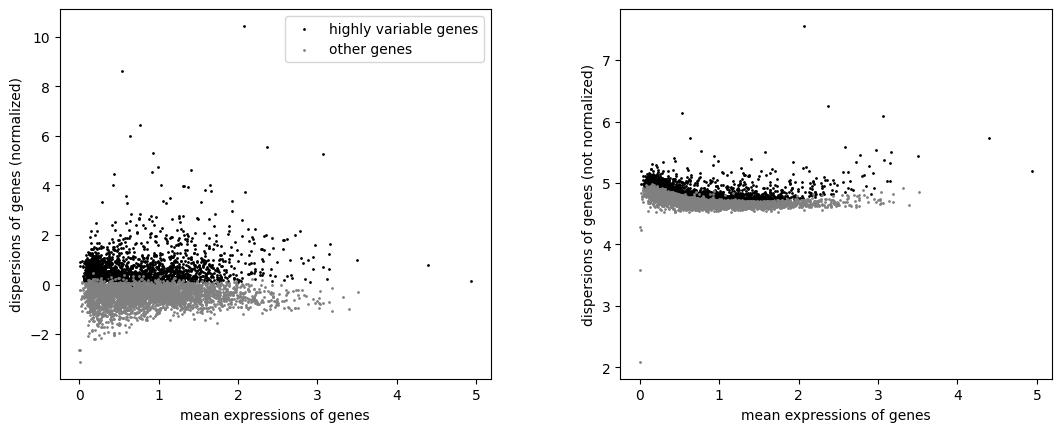

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
adata

AnnData object with n_obs × n_vars = 646121 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'sample', 'graphclust', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'megagut_lvl3_predicted_labels', 'megagut_lvl3_over_clustering', 'megagut_lvl3_majority_voting', 'megagut_lvl3_conf_score', 'megagut_lvl1_predicted_labels', 'megagut_lvl1_over_clustering', 'megagut_lvl1_majority_voting', 'megagut_lvl1_conf_score', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'MF1_prob', 'MF2_prob', 'PC_prob', 'S1_prob', 'S2_prob', 'S3_prob', 'S3x_prob', 'S4_prob', 'S5_prob',

# Integration

In [25]:
# Recompute dimensionality reduction across samples
sc.pp.pca(adata)

In [26]:
#sc.pp.neighbors(adata)  # without batch correction
#sc.external.pp.bbknn(adata, batch_key='sample')  # with batch correction

In [28]:
# scVI
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="sample")

model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [29]:
model.train()

INFO: GPU available: False, used: False
GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/12 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=12` reached.
`Trainer.fit` stopped: `max_epochs=12` reached.


In [30]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [31]:
sc.pp.neighbors(adata, use_rep="X_scVI")

In [32]:
# Clustering
sc.tl.leiden(adata)  # runtime: 45m

In [33]:
# UMAP
sc.tl.umap(adata)

# Plots

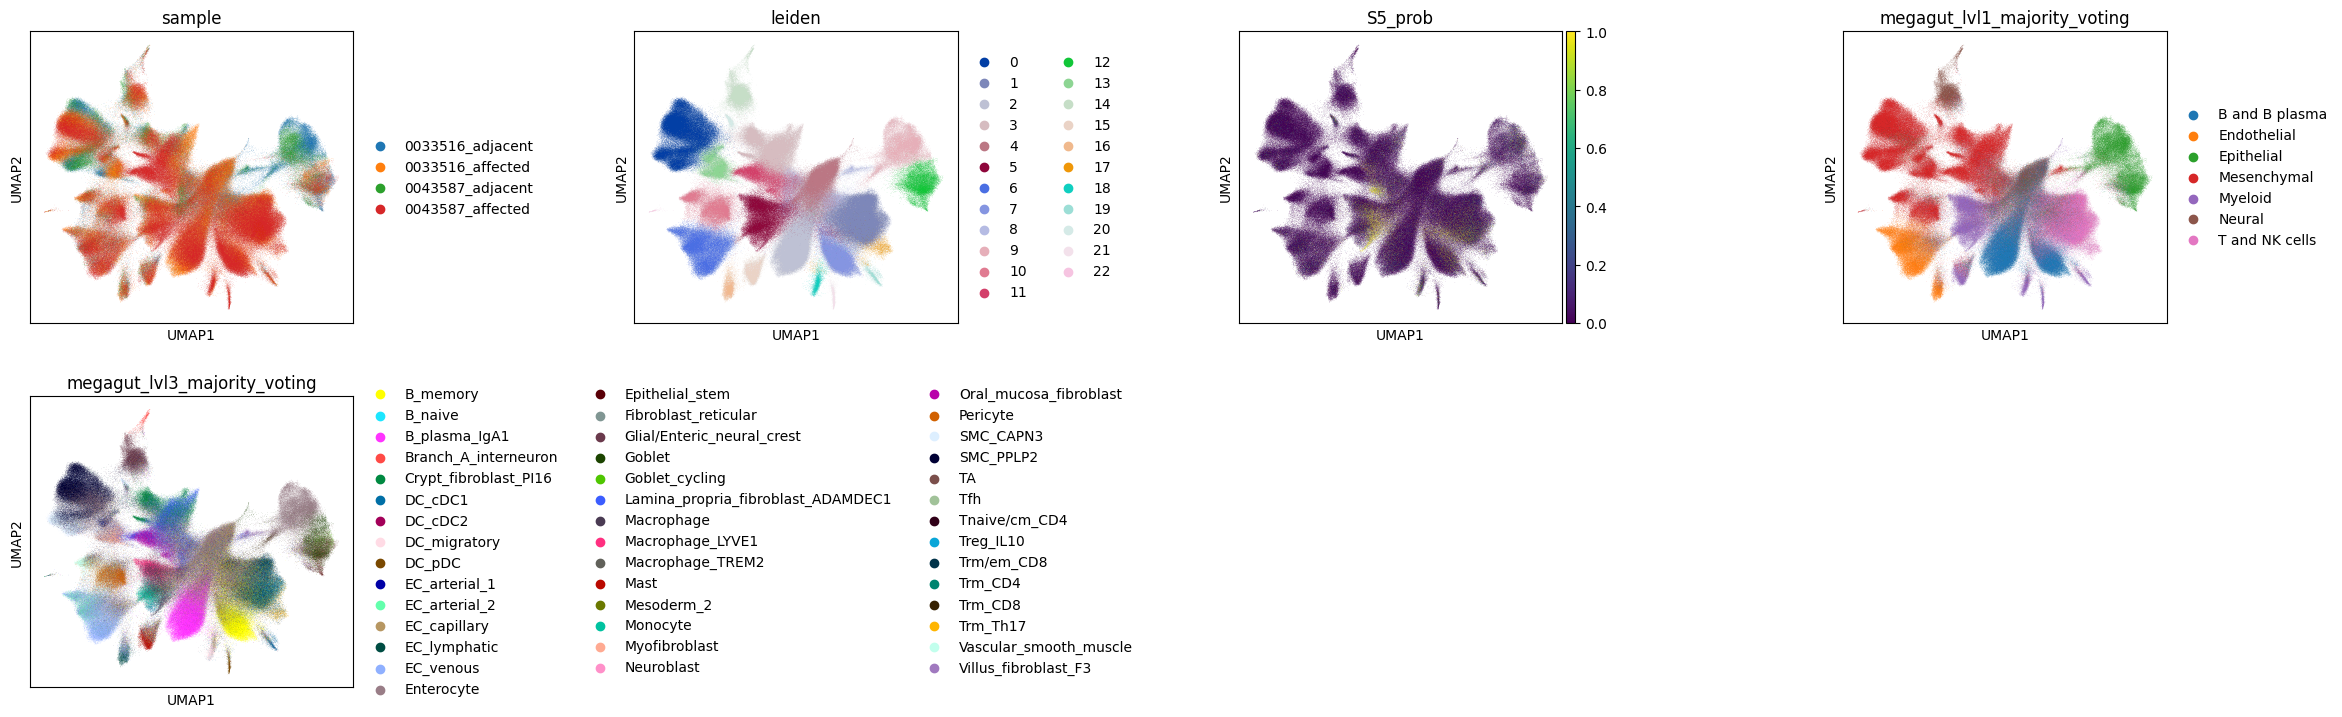

In [34]:
rcParams["figure.figsize"] = (4, 4)

sc.pl.umap(
    adata,
    color=[
        "sample", "leiden", "S5_prob", "megagut_lvl1_majority_voting", "megagut_lvl3_majority_voting"
    ],
    wspace=0.7,
    #palette=sc.pl.palettes.default_28
    #palette=sc.pl.palettes.default_102
    #palette=sc.pl.palettes.vega_20_scanpy
)

In [116]:
# rcParams["figure.figsize"] = (4, 4)

# sc.pl.umap(
#     adata,
#     color=[
#         "annot_matthias"
#     ],
#     wspace=0.7,
# #    legend_loc="on data"
#     #palette=sc.pl.palettes.default_28
#     #palette=sc.pl.palettes.default_102
#     palette=sc.pl.palettes.vega_20_scanpy
# )

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "annot_matthias"
    ],
    wspace=0.7,
    #palette=sc.pl.palettes.default_28
    #palette=sc.pl.palettes.default_102
    palette=sc.pl.palettes.vega_20_scanpy
)

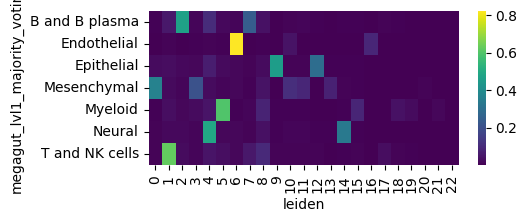

In [36]:
conf_mat = sc.metrics.confusion_matrix("megagut_lvl1_majority_voting", "leiden", adata.obs)
rcParams['figure.figsize'] = 5, 2.0
sns.heatmap(
    conf_mat,
    xticklabels=True,
    yticklabels=True,
    cmap='viridis'
)

plt.show()

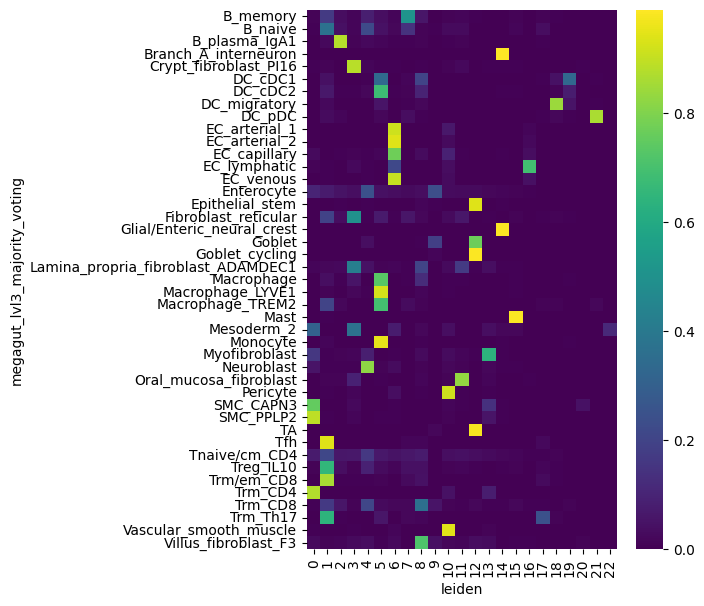

In [37]:
conf_mat = sc.metrics.confusion_matrix("megagut_lvl3_majority_voting", "leiden", adata.obs)
rcParams['figure.figsize'] = 5, 7.0
sns.heatmap(
    conf_mat,
    xticklabels=True,
    yticklabels=True,
    cmap='viridis'
)

plt.show()

In [38]:
adata.obs.annot_matthias = adata.obs.annot_matthias.cat.add_categories("unknown").fillna("unknown")

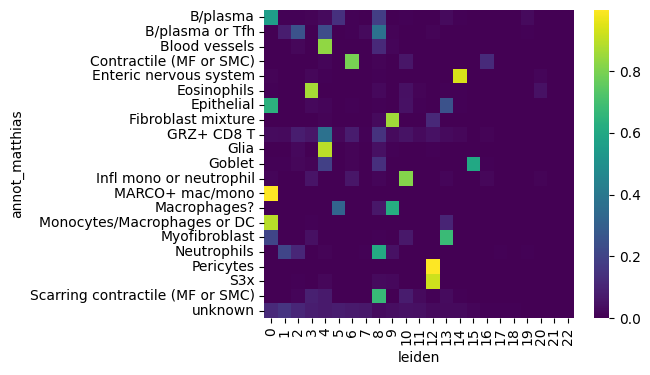

In [39]:
#adata_sub = adata[~adata.obs.annot_matthias.isna()]
conf_mat = sc.metrics.confusion_matrix("annot_matthias", "leiden", adata.obs)
rcParams['figure.figsize'] = 5, 4.0
sns.heatmap(
    conf_mat,
    xticklabels=True,
    yticklabels=True,
    cmap='viridis'
)

plt.show()

In [90]:
# # Broad annotation
# # Might be overwritten later
# adata.obs['annot_level1'] = adata.obs.leiden.copy()

# adata.obs.annot_level1 = adata.obs.annot_level1.replace({
#     '0': 'Mesenchymal',
#     '1': 'T and NK cells',
#     '2': 'B and B plasma',
#     '3': 'Neural',
#     '4': 'B and B plasma',
#     '5': 'Myeloid',
#     '6': 'Endothelial',
#     '7': 'B and B plasma',
#     '8': 'Epithelial',
#     '9': 'Mesenchymal',
#     '10': 'Epithelial',
#     '11': 'Mesenchymal',
#     '12': 'Neural',
#     '13': 'Myeloid',
#     '14': 'Mesenchymal',
#     '15': 'Endothelial',
#     '16': 'Myeloid',
#     '17': 'Myeloid',
#     '19': 'Myeloid',
# })

In [91]:
# adata.obs.annot_level1.value_counts()

In [92]:
# rcParams["figure.figsize"] = (4, 4)

# sc.pl.umap(
#     adata,
#     color=[
#         "annot_level1"
#     ],
#     wspace=0.7,
#     #palette=sc.pl.palettes.default_28
#     #palette=sc.pl.palettes.default_102
# #    palette=sc.pl.palettes.vega_20_scanpy
# )

In [93]:
# adata

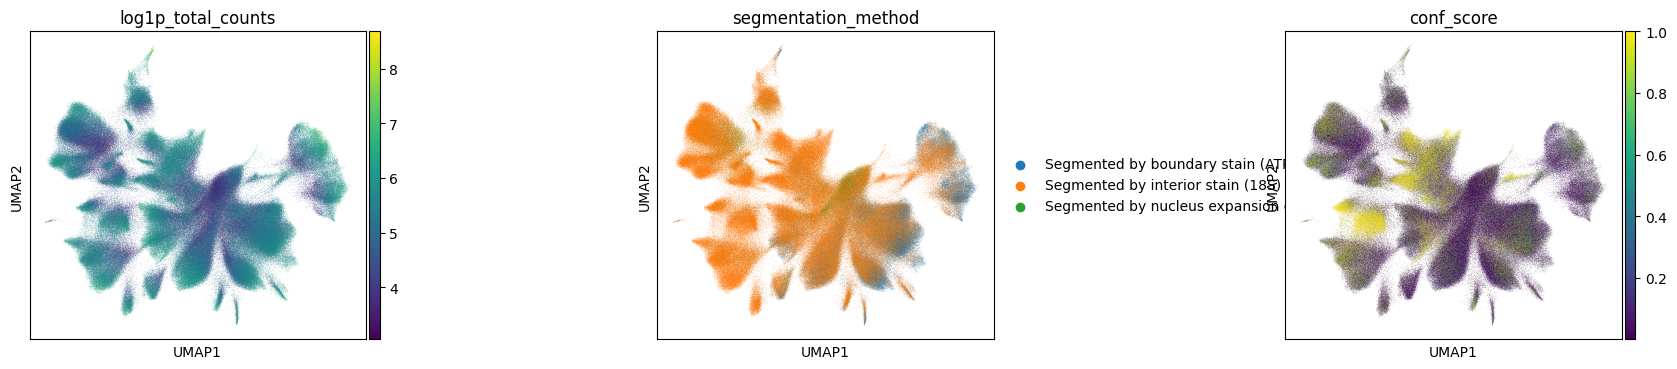

In [44]:
rcParams["figure.figsize"] = (4, 4)

sc.pl.umap(
    adata,
    color=[
        "log1p_total_counts", "segmentation_method", "conf_score"
    ],
    wspace=0.7,
    #palette=sc.pl.palettes.default_28
    #palette=sc.pl.palettes.default_102
    #palette=sc.pl.palettes.vega_20_scanpy
)

In [45]:
# rcParams["figure.figsize"] = (4, 4)

# sc.pl.umap(
#     adata,
#     color=[
#         "sample", "leiden", "S5_prob", "megagut_lvl1_majority_voting", "megagut_lvl3_majority_voting", 
#     ],
#     wspace=0.7,
#     #palette=sc.pl.palettes.default_28
#     #palette=sc.pl.palettes.default_102
#     #palette=sc.pl.palettes.vega_20_scanpy
# )

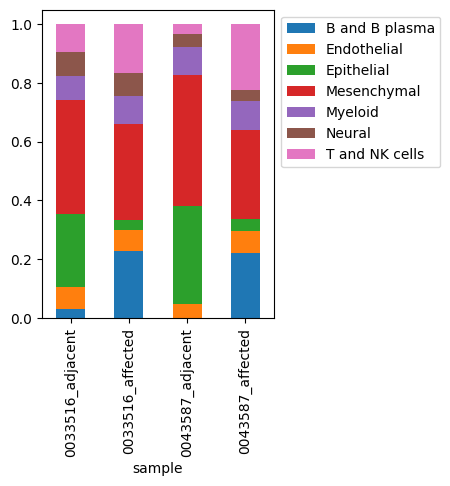

In [46]:
rcParams["figure.figsize"] = (3, 4)


# Get dictionary of colors
color_dict = dict(zip(adata.obs.megagut_lvl1_majority_voting.cat.categories, adata.uns['megagut_lvl1_majority_voting_colors']))

counts = pd.crosstab(adata.obs.megagut_lvl1_majority_voting, adata.obs['sample'], normalize='columns')
ax = counts.T.plot(kind='bar', stacked=True, color=counts.index.map(color_dict))
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.grid(False)

plt.savefig("figures/barplot_xenium5k_celltypist_level1.pdf", bbox_inches ="tight")

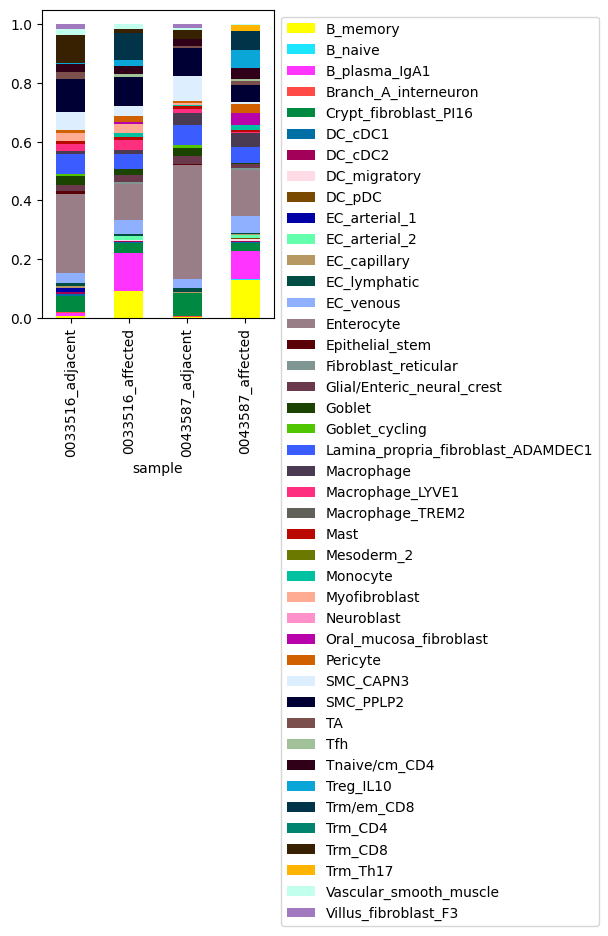

In [47]:
# Get dictionary of colors
color_dict = dict(zip(adata.obs.megagut_lvl3_majority_voting.cat.categories, adata.uns['megagut_lvl3_majority_voting_colors']))

counts = pd.crosstab(adata.obs.megagut_lvl3_majority_voting, adata.obs['sample'], normalize='columns')
ax = counts.T.plot(kind='bar', stacked=True, color=counts.index.map(color_dict))
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.grid(False)

plt.savefig("figures/barplot_xenium5k_celltypist_level3.pdf", bbox_inches ="tight")

In [48]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

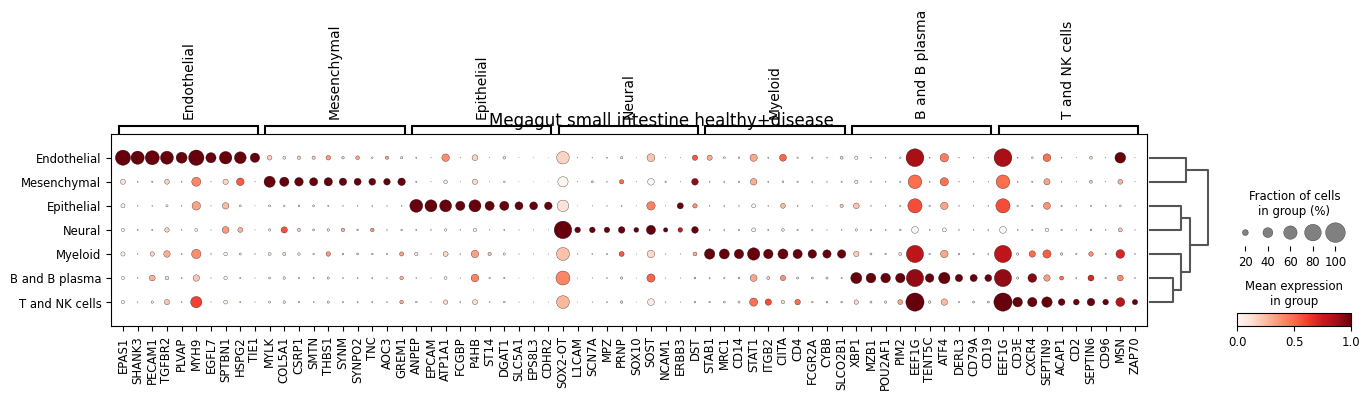

In [49]:
# Investigate markers of CellTypist labels
sc.tl.rank_genes_groups(adata, groupby='megagut_lvl1_majority_voting', method='wilcoxon')

sc.pl.rank_genes_groups_dotplot(
    adata, groupby='megagut_lvl1_majority_voting', standard_scale="var", n_genes=10, title="Megagut small intestine healthy+disease", figsize=(16, 2.5)
)

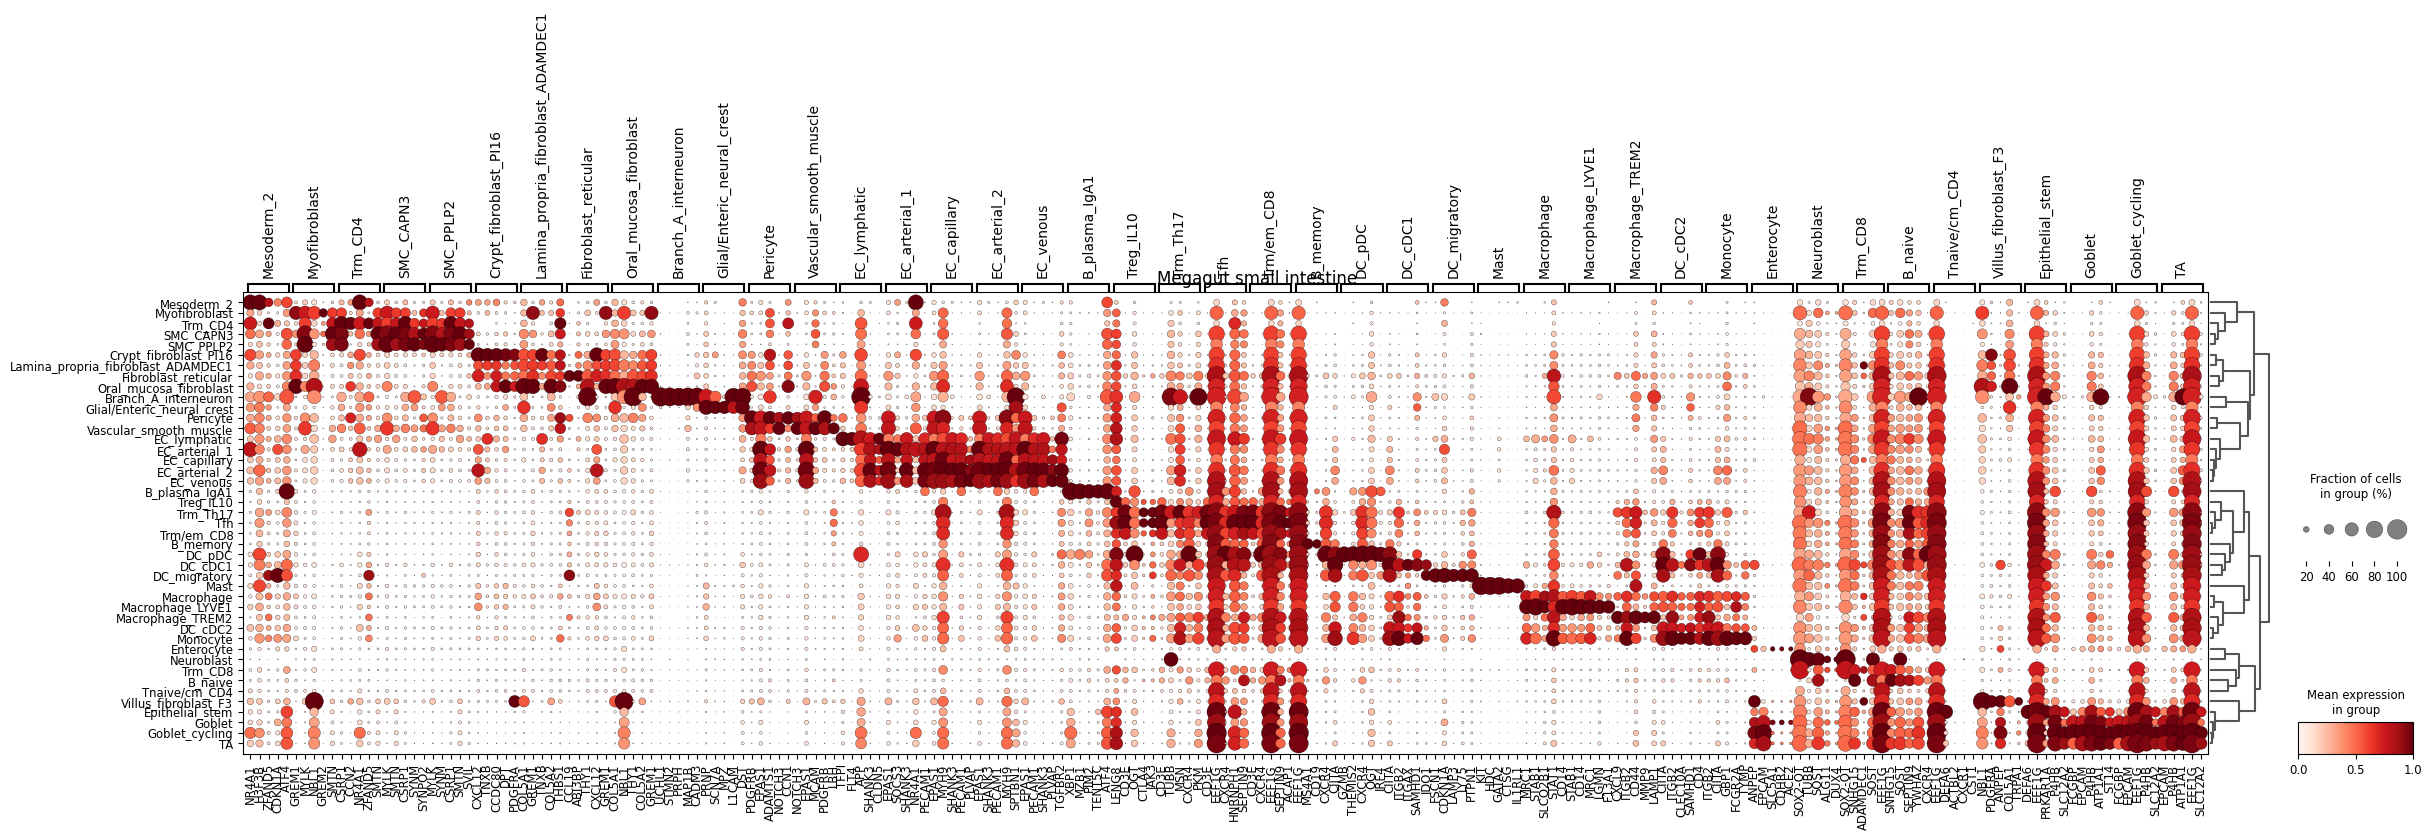

In [50]:
# Investigate markers of CellTypist labels
sc.tl.rank_genes_groups(adata, groupby='megagut_lvl3_majority_voting', method='wilcoxon')

sc.pl.rank_genes_groups_dotplot(
    adata, groupby='megagut_lvl3_majority_voting', standard_scale="var", n_genes=5, title="Megagut small intestine", figsize=(28, 6)
)

In [51]:
#adata.obs['sample'].value_counts()

In [52]:
# Create new clean annotation by excluding CellTypist cells that are not mesenchymal
adata.obs['annot_level1'] = pd.NA

In [103]:
# Some formatting
adata.obs = adata.obs.drop(columns='annot_level1')

In [111]:
adata.obs = adata.obs.rename(columns={
    'predicted_labels': 'fibro_predicted_labels',
    'over_clustering': 'fibro_over_clustering',
    'majority_voting': 'fibro_majority_voting',
    'conf_score': 'fibro_conf_score'
})

In [112]:
adata

AnnData object with n_obs × n_vars = 646121 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'sample', 'graphclust', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'megagut_lvl3_predicted_labels', 'megagut_lvl3_over_clustering', 'megagut_lvl3_majority_voting', 'megagut_lvl3_conf_score', 'megagut_lvl1_predicted_labels', 'megagut_lvl1_over_clustering', 'megagut_lvl1_majority_voting', 'megagut_lvl1_conf_score', 'fibro_predicted_labels', 'fibro_over_clustering', 'fibro_majority_voting', 'fibro_conf_score', 'MF1_prob', 'MF2_prob', 'PC_prob', 'S1_prob', 'S2_prob', 'S3_prob', 'S3x_prob

In [113]:
adata.write_h5ad("h5ad/xenium5k_scVI.h5ad")

## Spatial

In [ ]:
sc.set_figure_params(dpi_save=300)

sq.pl.spatial_scatter(
    adata_mesen[adata_mesen.obs['sample'] == '0033516_affected'],
    library_id="spatial",
    shape=None,
    color=[
        "subtype_annot", 
    ],
    wspace=0.1,
    size=0.5,
    figsize=(6, 6),
    na_color='lightgrey',
#    save="spatial_MF2_mesenchymal_fibroSubtypes.pdf",
   # dpi=600
)

In [ ]:
adata

In [ ]:
sq.pl.spatial_scatter(
    adata[adata.obs['sample'] == '0033516_affected'],
    library_id="spatial",
    shape=None,
    color=[
        "megagut_lvl1_majority_voting", "megagut_lvl3_majority_voting"
    ],
    wspace=0.4,
    size=0.2,
    figsize=(6, 6),
    na_color='lightgrey',
#    save="spatial_MF2_megagut_celltypist.pdf"
)

## Test all gene fibroblast model

### Load all gene CellTypist model

In [ ]:
# # Load all gene fibroblast model
# model_fibro = models.Model.load("../fibroblast_reanalysis_celltypist/celltypist/friedrich_fibroblasts_allGenes.pkl")
# model_fibro

In [ ]:
# # Relabel barcodes to make unique across samples
# adata_mesen.obs.index = adata_mesen.obs['sample'].astype(str) + '_' + adata_mesen.obs.index.astype(str)

In [ ]:
# # Run celltypist on data
# # All gene fibroblast model
# predictions = celltypist.annotate(
#     adata_mesen,
#     model = model_fibro,
#     majority_voting = True,
#     mode = 'prob match',
#     p_thres = 0.5)

In [ ]:
# predictions

In [ ]:
# predictions.predicted_labels.majority_voting.value_counts()

In [ ]:
# adata_mesen = predictions.to_adata(insert_prob=True)

In [ ]:
# adata_mesen

In [ ]:
# subtypes = ['MF1', 'MF2', 'PC', 'S1', 'S2', 'S3', 'S3x', 'S4', 'S5']

# adata_mesen.obs = adata_mesen.obs.rename(columns={x: x + "_prob2" for x in subtypes})

In [ ]:
# adata_mesen

In [ ]:
# # Plots of all posterior probabilityes per fibroblast sybtype
# rcParams["figure.figsize"] = (3, 3)

# sc.pl.umap(adata_mesen, color=["majority_voting"], color_map="magma_r", frameon=False, size=1,
#            #save="_megagut_fibro_celltypist_probs"
# )

In [ ]:
# # Plots of all posterior probabilityes per fibroblast sybtype
# rcParams["figure.figsize"] = (3, 3)

# sc.pl.umap(adata_mesen, color=[x + "_prob2" for x in subtypes], color_map="magma_r", frameon=False, size=1,
#            #save="_megagut_fibro_celltypist_probs"
# )

# Graveyard

In [ ]:
# sq.pl.spatial_scatter(
#     adata_mesen[adata_mesen.obs['sample'] == 'MF1_resegment'],
#     library_id="spatial",
#     shape=None,
#     color=[
#         "leiden", "S5_prob", "MF2_prob", "MF1_prob", "PC_prob", "S1_prob",  "S2_prob",  "S3_prob",  "S3x_prob", 
#     ],
#     wspace=0.1,
#     size=0.1,
#     figsize=(8,8)
# )

In [ ]:
# # Load celltypist models of fibroblasts from Friedrich (our) study
# model_fibro = models.Model.load("../fibroblast_reanalysis_celltypist/celltypist/friedrich_fibroblasts.pkl")

In [ ]:
# Clear previous columns 
#adata_mesen.obs = adata_mesen.obs.drop(columns=['predicted_labels', 'majority_voting', 'conf_score'])

In [ ]:
# # Run celltypist on mesenchymal data
# predictions = celltypist.annotate(
#     adata_mesen,
#     model = model_fibro,
#     majority_voting = True,
#     mode = 'prob match',
#     p_thres = 0.5)

In [ ]:
# predictions

In [ ]:
# predictions.predicted_labels.majority_voting.value_counts()

In [ ]:
# adata_mesen

In [ ]:
# predictions.probability_matrix

In [ ]:
#pd.merge(adata_mesen.obs, predictions.probability_matrix, how='left')

In [ ]:
# adata_mesen.obs

In [ ]:
# adata_mesen.obs.join(predictions.probability_matrix, how='left')

In [ ]:
# # Add probability matrix
# adata_mesen.obs = adata_mesen.obs.join(predictions.probability_matrix, how='left')

In [ ]:
#adata_mesen.obs = adata_mesen.obs.drop(columns=['predicted_labels', 'majority_voting', 'conf_score'])

In [ ]:
#adata_mesen = adata_mesen.copy()

In [ ]:
#predictions.to_adata(insert_labels=False)

In [ ]:
# Add celltypist results to AnnData object
# Columns: 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'MF1', 'MF2', 'PC', 'S1', 'S2', 'S3', 'S3x', 'S4', 'S5'
#adata_mesen = predictions.to_adata(insert_prob=False, prefix='mesenchymal_')
#adata_mesen = predictions.to_adata(prefix='mesenchymal_')